## Install and import the dependencies

In [1]:
!pip install keras tensorflow transformers sentencepiece -U 

     |████████████████████████████████| 1.2 MB 9.3 MB/s eta 0:00:01
     |████████████████████████████████| 394.3 MB 6.9 kB/s  eta 0:00:01███████████████████████       | 309.0 MB 71.4 MB/s eta 0:00:02
     |████████████████████████████████| 127 kB 67.8 MB/s eta 0:00:01
     |████████████████████████████████| 3.8 MB 53.2 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 2.3 MB/s  eta 0:00:01
     |████████████████████████████████| 65 kB 845 kB/s  eta 0:00:01
     |████████████████████████████████| 10.6 MB 66.7 MB/s eta 0:00:01
     |████████████████████████████████| 116 kB 71.2 MB/s eta 0:00:01
     |████████████████████████████████| 96 kB 8.9 MB/s  eta 0:00:01
     |████████████████████████████████| 155 kB 72.1 MB/s eta 0:00:01
     |████████████████████████████████| 147 kB 70.7 MB/s eta 0:00:01
     |████████████████████████████████| 781 kB 58.8 MB/s eta 0:00:01
     |████████████████████████████████| 462 kB 23.3 MB/s eta 0:00:01
     |████████████████████████████████| 1.

In [2]:
# import depenencies
import pandas as pd
import numpy as np
import boto3
import sagemaker
import pickle
import os
from keras.preprocessing.sequence import pad_sequences
import torch
from matplotlib import pyplot as plt

%matplotlib inline


## Load and clean data

In [3]:
# path to data directory
data_dir = 'data'

In [4]:
# load the data into dataframes
train_df = pd.read_csv(os.path.join(data_dir, "train_file.csv"), delimiter='\t', header=None)
test_df = pd.read_csv(os.path.join(data_dir, "test_file.csv"), delimiter='\t', header=None)
train_df = train_df.rename(columns = {0:'word', 1:'wordnum', 5:'label'})
test_df = test_df.rename(columns = {0:'word', 1:'wordnum', 5:'label'})
train_df.head()

,word,wordnum,2,3,4,label
0,1$1/4,I1,L20,NoCAP,NoPAREN,B-QTY
1,cups,I2,L20,NoCAP,NoPAREN,B-UNIT
2,cooked,I3,L20,NoCAP,NoPAREN,B-COMMENT
3,and,I4,L20,NoCAP,NoPAREN,I-COMMENT
4,pureed,I5,L20,NoCAP,NoPAREN,I-COMMENT


First, we noticed that there a lot of noise in the word column that manifest itself as very long strings:

In [5]:
train_df[train_df.word.map(lambda x: len(x)) > 20]

,word,wordnum,2,3,4,label
6948,"href=""http://cooking.nytimes.com/recipes/1678-...",I6,L12,NoCAP,YesPAREN,OTHER
8503,"href=""http://cooking.nytimes.com/recipes/1665-...",I7,L12,NoCAP,YesPAREN,OTHER
11747,"href=""http://cooking.nytimes.com/recipes/399-o...",I5,L8,NoCAP,YesPAREN,OTHER
11900,"href=""http://cooking.nytimes.com/recipes/396-t...",I5,L8,NoCAP,YesPAREN,OTHER
12133,"href=""http://cooking.nytimes.com/recipes/1779-...",I8,L12,NoCAP,YesPAREN,OTHER
...,...,...,...,...,...,...
840421,"href=""http://cooking.nytimes.com/recipes/10758...",I4,L8,NoCAP,NoPAREN,OTHER
844762,"href=""http://cooking.nytimes.com/recipes/448-a...",I14,L20,NoCAP,YesPAREN,OTHER
848472,"href=""http://cooking.nytimes.com/recipes/10178...",I5,L8,NoCAP,NoPAREN,OTHER
848934,"href=""http://cooking.nytimes.com/recipes/10178...",I7,L12,NoCAP,YesPAREN,OTHER


We'll clean the data from the links and look at it again to see what kind of partterns are there in the data noise:

In [6]:
train_df = train_df[~train_df.word.str.contains('http://')]
train_df[train_df.word.map(lambda x: len(x)) > 20]

,word,wordnum,2,3,4,label
83213,Butter-and-Shortening,I8,L16,YesCAP,YesPAREN,I-COMMENT
108999,rice\tI10\tL16\tNoCAP\tYesPAREN\tI-COMMENT\nst...,I11,L16,NoCAP,YesPAREN,I-COMMENT
144280,bittersweet-chocolate,I3,L8,NoCAP,NoPAREN,B-NAME
217538,www.aquavitnewyork.com,I11,L20,NoCAP,YesPAREN,I-COMMENT
231693,1-and-a-half-inch-thick,I2,LX,NoCAP,NoPAREN,B-COMMENT
238706,Roasted-lemon-and-garlic,I1,L12,YesCAP,NoPAREN,B-NAME
246539,"target=""_blank"">basic",I5,L8,NoCAP,NoPAREN,OTHER
340115,one-and-one-fourth-inch,I12,L16,NoCAP,NoPAREN,I-COMMENT
340127,one-and-a-fourth-inch,I11,L16,NoCAP,NoPAREN,I-COMMENT
347459,1/4-inch-by-1$1/2-inch,I11,L16,NoCAP,NoPAREN,I-COMMENT


Second, taking a look on the tag names we can see that some of them are unnessasary for our goal of extracting ingredient name, quantity and unit out of an ingredient phrase:

In [7]:
pd.concat([train_df, test_df]).label.value_counts()

I-COMMENT       224850
B-NAME          180633
B-QTY           146326
OTHER           140216
I-NAME          136407
B-UNIT          117938
B-COMMENT       116487
B-RANGE_END       1855
I-UNIT             104
B-UNNAMED: 0         3
Name: label, dtype: int64

For example, I-COMMENT, B-COMMENT and OTHER tag any tokens or punctuation, not included in any of the ingredient name, quantity or units, We can replace them with a single tag:

In [8]:
train_df[train_df.label == 'B-COMMENT'].word.value_counts()

,                 10956
to                 5588
or                 3721
freshly            3613
chopped            3589
                  ...  
European-style        1
fragrant              1
unprocessed           1
dough                 1
slit                  1
Name: word, Length: 2432, dtype: int64

In [9]:
train_df[train_df.label == 'I-COMMENT'].word.value_counts()

and          8289
taste        6636
chopped      6478
,            5991
or           5313
             ... 
Lao             1
Cooked          1
halve           1
greenings       1
Siljans         1
Name: word, Length: 5150, dtype: int64

In [10]:
train_df[train_df.label == 'OTHER'].word.value_counts()

,                30119
(                 5643
)                 5628
or                4002
to                3331
                 ...  
Castlelfranco        1
glazing              1
and\nsliced          1
cups\ngrated         1
cleaned\nand         1
Name: word, Length: 4123, dtype: int64

Also, two rare tags 'B_UNNAMED: 0' really shoud tag quantities:

In [11]:
train_df[train_df.label == 'B-UNNAMED: 0']

,word,wordnum,2,3,4,label
17,1,I1,L8,NoCAP,NoPAREN,B-UNNAMED: 0
24,2,I1,L8,NoCAP,NoPAREN,B-UNNAMED: 0


Finally, here is our resulting function for cleaning the data

In [12]:
def clean_data(df):
    """
    Cleaning the dataframe df
    """
    df.label = df.label.str.replace('I-COMMENT', 'OTHER')
    df.label = df.label.str.replace('B-COMMENT', 'OTHER')
    df.label = df.label.str.replace('B-UNNAMED: 0', 'B-QTY')


    df = df[~df.word.str.contains('http://')]
    df = df[~df.word.str.contains('>')]
    df = df[~df.word.str.contains(r'\\t')]
    df = df[~df.word.str.contains(r'\\n')]
    df = df[~df.word.str.contains('.com')]
    return df


In [13]:
train_df_cleaned = clean_data(train_df)
test_df_cleaned = clean_data(test_df)

We'll save the cleaned dataframe for training the benchmark model and for further processing:

In [14]:
train_df_cleaned.to_csv(os.path.join(data_dir, 'train_file_cleaned.csv'), sep='\t', index=False, header=False)
test_df_cleaned.to_csv(os.path.join(data_dir, 'test_file_cleaned.csv'), sep='\t', index=False, header=False)

# Analyze data

In [15]:
# load the data into dataframes
train_df = pd.read_csv(os.path.join(data_dir, "train_file_cleaned.csv"), delimiter='\t', header=None, usecols=[0,1,5],  names=['word', 'wordnum', 'label'])
test_df = pd.read_csv(os.path.join(data_dir, "test_file_cleaned.csv"), delimiter='\t', header=None, usecols=[0,1,5],  names=['word', 'wordnum', 'label'])

In [16]:
train_df = pd.concat([train_df, test_df], axis=0)

We'll look at final label distribution to see if the classes are not too skewed. Looks like it is has larger number of 'OTHER' tag, but not sugnificantly, comparing to all other tag counts.


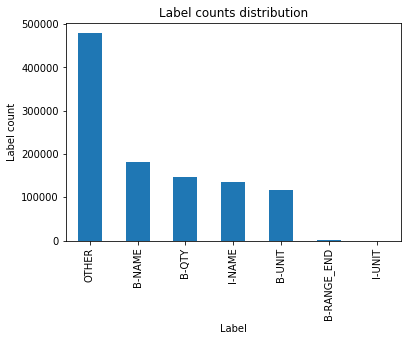

In [17]:
train_df.label.value_counts().plot(kind='bar')
plt.title('Label counts distribution')
plt.xlabel('Label')
plt.ylabel('Label count');


We'll now convert the data from te dataframes to sentences and look at their length distibutions.

In [18]:
def data_to_sentences(df):
    """
    Extracts sentences and tokens out of the dataframe df

    Parameters:
        df - pandas dataframe with the data

    Returns: 
        sentence_list - list of sentences, split to list of words
        labels_list - list of label lists for each sentence
    """
    sentence = []
    sentence_list = []
    labels = []
    labels_list = []
    for row in df.itertuples():   
        if row.wordnum == 'I1':
            sentence_list.append(sentence)
            labels_list.append(labels)
            sentence = []
            labels = []
        sentence.append(row.word)
        labels.append(row.label)

    sentence_list.append(sentence)
    labels_list.append(labels)
    
    sentence_list.pop(0)
    labels_list.pop(0)
    
    return sentence_list, labels_list


In [19]:
train_sentences, train_labels = data_to_sentences(train_df)

Plot the histogram of the sentences lengths:

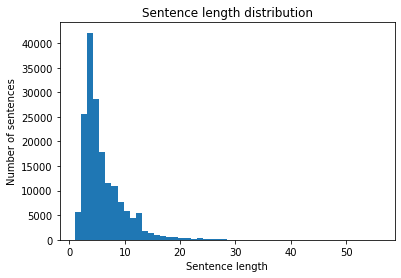

In [20]:
plt.hist([len(s) for s in train_sentences], bins=50)
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.title('Sentence length distribution');

We'll use this to set 30 words as our value for padding, since most of the sentences are under this length.

# Process and save data for training

In [21]:
# functions for data processing

MAX_LEN = 30

def convert_and_pad_sentences(sentence_list, tokenizer, maxlen):
    """
    Tokenizes the list of sentences, and pads them to the maxlen length
    
    Parameters:
        sentence_list (list) - list of sentences, split by words
        tokenizer (Tokenizer) - tokenizer
        maxlen (int) - lengh to pad/truncate the sentences to

    Returns:
        padded_sents (list) - tokenized and padded sentences
    """
    sentences = [" ".join([word for word in sent]) for sent in sentence_list]
    encoded_sents = [tokenizer.encode(sent,add_special_tokens = True) 
                     for sent in sentences]
    padded_sents = pad_sequences(encoded_sents, maxlen=maxlen, dtype="long", 
                          value=0, truncating="post", padding="post")
    return padded_sents

def convert_and_pad_labels(tags_list, tag_dict, maxlen):
    """
    Converts the list of tag sequences to integers and pads them to the maxlen
    length

    Parameters:
        tag_list (list) - list of tag sequences
        tag_dict (dict) - dictionary of tags to their integer ids
        maxlen (int) - length to pad/truncate the tag sequences to

    Returns:
        padded_tags (list) - padded sequences of tag ids
    """
    tag_ids = [[tag_dict[t] for t in s] for s in tags_list]
    padded_tags = pad_sequences(tag_ids, maxlen=maxlen, dtype="long", 
                          value=0, truncating="post", padding="post")
    return padded_tags


In [22]:
#tag dictionary
tag_dict = {'PAD': 0, 
            'B-QTY': 1,  
            'B-RANGE_END': 2,
            'B-UNIT': 3,  
            'I-UNIT': 4,
            'B-NAME': 5,
            'I-NAME': 6,
            'OTHER': 7}

Next we'll get the data ready for model training and save it to the disk.

In [24]:
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 
                           'tokenizer', 
                           'bert-base-uncased')   

train_X = convert_and_pad_sentences(train_sentences, tokenizer, MAX_LEN)
train_y = convert_and_pad_labels(train_labels, tag_dict, MAX_LEN)


Using cache found in /home/ec2-user/.cache/torch/hub/huggingface_pytorch-transformers_master


In [25]:
with open(os.path.join(data_dir, 'train_data.pkl'), "wb") as f:
    pickle.dump((train_X, train_y), f)